In [1]:
import random
from matplotlib import pyplot as plt
from scipy.optimize import leastsq
from scipy.optimize import least_squares
import numpy as np
import csv

In [2]:
class Winters:
    
    def __init__(self, data):
        self.alpha = 0.05
        self.beta = 0.05
        self.gamma = 0.05
        self.season = 3
        self.series = {}
        self.data_size = len(data)
        for t in range(1, self.data_size + 1):
            self.series[t] = data[t - 1]
        
    def forecast_add(self, coefs, n=0, nonnegative=True):
        alpha_, beta_, gamma_, r = coefs
        r = int(r)
        if r < 0: 
            print(r)
        
        y = self.series # empiric series
        N = self.data_size # empiric series size
        F, S, C = {}, {}, {} # model partials
        yf = {} # modeled series
        # calculate initial partials
        F[r + 1] = 1.0 / r * sum([y[i] for i in range(1, r + 1)])
        S[r + 1] = -F[r + 1] + 1.0 / r * sum([y[i] for i in range(r + 1, 2 * r + 1)])
        for t in range(1, r + 1):
            C[t] = y[t] - F[r + 1]
        C[r + 1] = gamma_ * (y[r + 1] - F[r + 1]) + (1 - gamma_) * C[1]
        #
        for t in range(r + 2, N + n + 1):
            if t > N:
                yf[t] = F[N] + S[N] * (t - N) + C[t - r]
            else:
                F[t] = alpha_ * (y[t] - C[t - r]) + (1 - alpha_) * (F[t - 1] + S[t - 1])
                S[t] = beta_ * (F[t] - F[t - 1]) + (1 - beta_) * S[t - 1]
                C[t] = gamma_ * (y[t] - F[t]) + (1 - gamma_) * C[t - r]
                yf[t] = F[t - 1] + S[t - 1] + C[t - r]
            if yf[t] < 0 and nonnegative:
                    yf[t] = 0
        return yf
    
    def loss(self):
        ys = np.array(list(self.series.values())[self.season + 1:])
        fs = np.array(list(self.forecast_add([self.alpha, self.beta, self.gamma, self.season], 0).values()))
        return 0.5 * ((ys - fs)**2).sum()
    
    def fit_coefs(self):
        ys = np.array(list(self.series.values())[self.season + 1:])
        def residuals(coefs):
            coefs = np.append(coefs, self.season)
            return np.array(list(self.forecast_add(coefs, 0).values())) - ys
        self.alpha, self.beta, self.gamma = least_squares(fun=residuals,
                                                          x0=np.array([self.alpha, self.beta, self.gamma]),
                                                          bounds=([0.0, 0.0, 0.0], [1.0, 1.0, 1.0])).x
    # (self.alpha, self.beta, self.gamma), _ = leastsq(func=lambda coefs: np.array(self.forecast_add(coefs, 0).values()) - ys,
    # x0=np.array([self.alpha, self.beta, self.gamma]))
        
    def fit_coefs_season(self):
        # calculate residuals
        def residuals(cs):
            fs = list(self.forecast_add(cs, 0).values())
            fsize = len(fs)
            #print fsize, len(self.series.values()[-fsize:])
            ys = np.array(list(self.series.values())[-fsize:])
            return np.array(fs) - ys
        #
        res = least_squares(fun=residuals,
                            x0=np.array([self.alpha, self.beta, self.gamma, self.season]),
                            bounds=([0, 0, 0, 1], [1, 1, 1, int(self.data_size / 2)]),
                            #method='lm',
                            #max_nfev=100000
                           )
        # print res
        self.alpha, self.beta, self.gamma, self.season = res.x[0], res.x[1], res.x[2], int(res.x[3])
        
data = []
with open('../data/stacja1_logis.csv', 'r', encoding='utf-8') as csvfile:
    csv_reader = csv.reader(csvfile, delimiter=';', quotechar='.')
    for row in csv_reader:
        data.append(int(row[0].replace(" ", "")))

m = Winters(data)
m.fit_coefs_season()
print(m.season, m.alpha, m.beta, m.gamma)

3 0.22512028672727682 0.15593927999518628 0.10244338037322552


In [3]:
m = Winters(data)
m.fit_coefs()

# season size is not being optimized!
print(m.season, m.alpha, m.beta, m.gamma, m.loss())

3 0.22511088226405937 0.15597541190455558 0.10241661298937602 7276326288.169948


0.16558413554078208 0.1601734165258964 0.12408501849046304


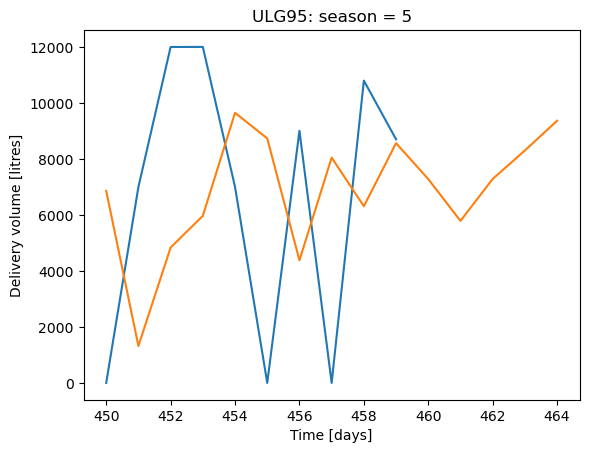

0.053396056303467145 0.07377408950344912 0.136167106767791


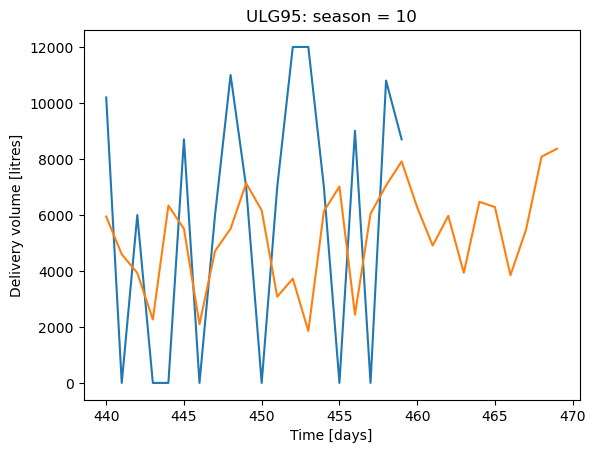

0.014628277568015267 0.11824923977082774 0.3143702568557925


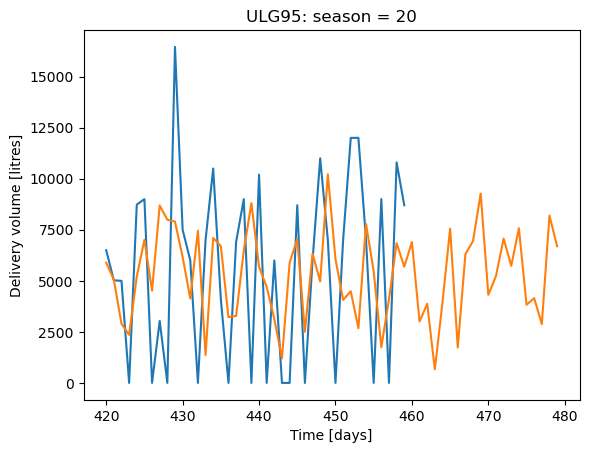

In [4]:
models = [Winters(data), Winters(data), Winters(data)]

models[0].season = 5
models[1].season = 10
models[2].season = 20

for m in models:
    m.fit_coefs()
    print(m.alpha, m.beta, m.gamma)
    fs_add = m.forecast_add([m.alpha, m.beta, m.gamma, m.season], n=m.season)

    plt.plot(list(m.series.keys())[-2 * m.season:],
             list(m.series.values())[-2 * m.season:])
    plt.plot(list(fs_add.keys())[-3 * m.season:],
             list(fs_add.values())[-3 * m.season:])
    plt.xlabel("Time [days]")
    plt.ylabel("Delivery volume [litres]")
    plt.title("ULG95: season = " + str(m.season))
    plt.show()


In [5]:
data1, data2, data3, data4 = [], [], [], []
with open('../data/stacja1_logis.csv', 'r', encoding='utf-8') as csvfile:
    csv_reader = csv.reader(csvfile, delimiter=';', quotechar='.')
    for row in csv_reader:
        data1.append(int(row[0].replace(" ", "")))
        data2.append(int(row[1].replace(" ", "")))
        data3.append(int(row[2].replace(" ", "")))
        data4.append(int(row[3].replace(" ", "")))

seasons = list(range(2, 62))
losses1, losses2, losses3, losses4 = [], [], [], []

for s in seasons:
    m1, m2, m3, m4 = Winters(data1), Winters(data2), Winters(data3), Winters(data4)
    m1.season = m2.season = m3.season = m4.season = s
    m1.fit_coefs(); m2.fit_coefs(); m3.fit_coefs(); m4.fit_coefs()
    #lf = m.loss()
    print(s)
    #print m.alpha, m.beta, m.gamma, lf
    losses1.append(np.log(m1.loss()))
    losses2.append(np.log(m2.loss()))
    losses3.append(np.log(m3.loss()))
    losses4.append(np.log(m4.loss()))


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61


In [6]:
losses1, losses2, losses3, losses4 = np.array(losses1), np.array(losses2), np.array(losses3), np.array(losses4)
    
min_s1 = 3 + losses1.argmin()
min_s2 = 3 + losses2.argmin()
min_s3 = 3 + losses3[5:].argmin() + 5
min_s4 = 3 + losses4.argmin()

print(min_s1, min_s2, min_s3, min_s4)

m1, m2, m3, m4 = Winters(data1), Winters(data2), Winters(data3), Winters(data4)
m1.season, m2.season, m3.season, m4.season = min_s1, min_s2, min_s3, min_s4
m1.fit_coefs(); m2.fit_coefs(); m3.fit_coefs(); m4.fit_coefs()
print(m1.alpha, m1.beta, m1.gamma, m1.season)
print(m2.alpha, m2.beta, m2.gamma, m2.season)
print(m3.alpha, m3.beta, m3.gamma, m3.season)
print(m4.alpha, m4.beta, m4.gamma, m4.season)


14 6 61 44
0.06215554760557036 0.14436295033144694 0.17739105209361386 14
0.0912470622863604 0.07506238721679101 0.059465352095989424 6
0.0003366297605446288 0.9999993338564989 0.3587425046744337 61
0.04181450341196685 0.10578594089554302 0.2707075235663384 44


In [7]:
losses1, losses2, losses3, losses4 = np.array(losses1), np.array(losses2), np.array(losses3), np.array(losses4)
    
min_s1 = 3 + losses1.argmin()
min_s2 = 3 + losses2.argmin()
min_s3 = 3 + losses3[5:].argmin() + 5
min_s4 = 3 + losses4.argmin()

print(min_s1, min_s2, min_s3, min_s4)

m1, m2, m3, m4 = Winters(data1), Winters(data2), Winters(data3), Winters(data4)
m1.season, m2.season, m3.season, m4.season = min_s1, min_s2, min_s3, min_s4
m1.fit_coefs(); m2.fit_coefs(); m3.fit_coefs(); m4.fit_coefs()
print(m1.alpha, m1.beta, m1.gamma, m1.season)
print(m2.alpha, m2.beta, m2.gamma, m2.season)
print(m3.alpha, m3.beta, m3.gamma, m3.season)
print(m4.alpha, m4.beta, m4.gamma, m4.season)


14 6 61 44
0.06215554760557036 0.14436295033144694 0.17739105209361386 14
0.0912470622863604 0.07506238721679101 0.059465352095989424 6
0.0003366297605446288 0.9999993338564989 0.3587425046744337 61
0.04181450341196685 0.10578594089554302 0.2707075235663384 44


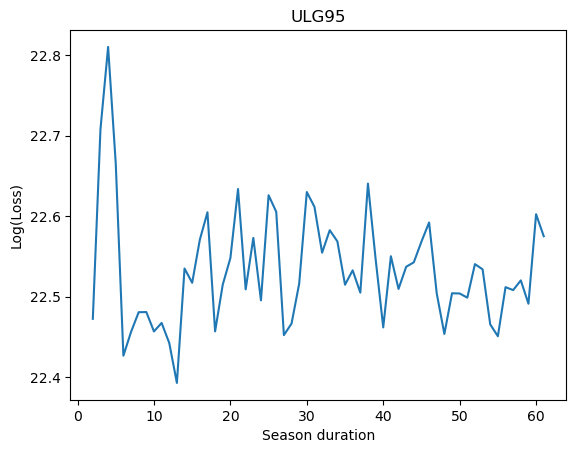

In [8]:
plt.plot(seasons, losses1)
plt.title("ULG95")
plt.xlabel("Season duration")
plt.ylabel("Log(Loss)")
plt.show()

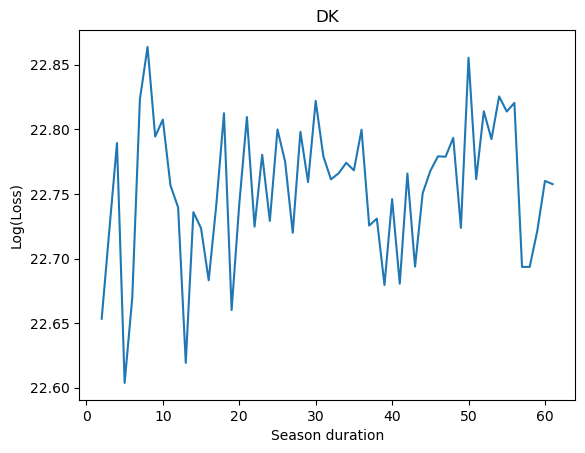

In [9]:
plt.plot(seasons, losses2)
plt.title("DK")
plt.xlabel("Season duration")
plt.ylabel("Log(Loss)")
plt.show()

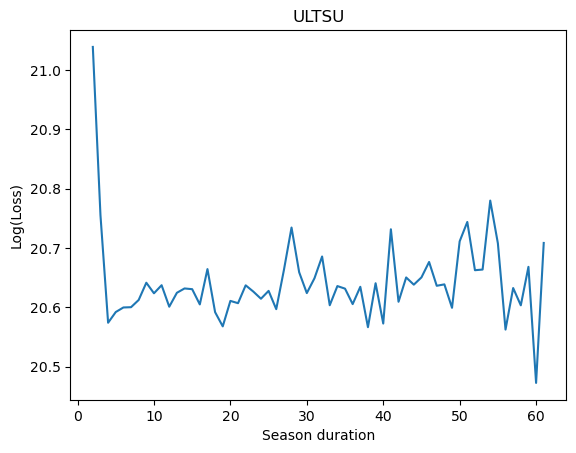

In [10]:
plt.plot(seasons, losses3)
plt.title("ULTSU")
plt.xlabel("Season duration")
plt.ylabel("Log(Loss)")
plt.show()

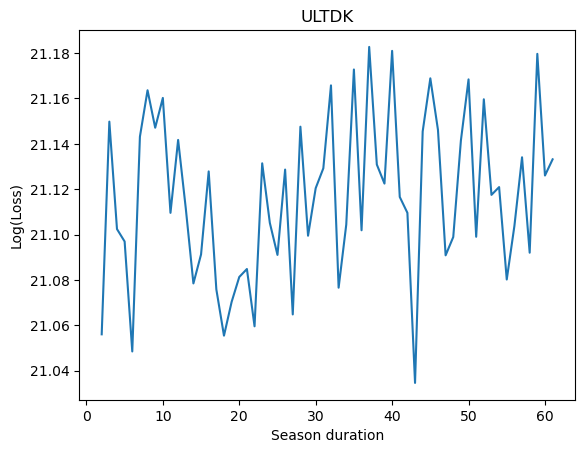

In [11]:
plt.plot(seasons, losses4)
plt.title("ULTDK")
plt.xlabel("Season duration")
plt.ylabel("Log(Loss)")
plt.show()